In [0]:
from keras import objectives, backend as K
from keras.layers import Bidirectional, Dense, Embedding, Input, Lambda, LSTM, RepeatVector, TimeDistributed, CuDNNLSTM
from keras.models import Model
import keras

Using TensorFlow backend.


In [0]:
class VAE(object):
    def create(self, vocab_size=500, max_length=300, latent_rep_size=200):
        self.encoder = None
        self.decoder = None
        self.sentiment_predictor = None
        self.autoencoder = None

        x = Input(shape=(max_length,))
        x_embed = Embedding(vocab_size, 64, input_length=max_length)(x)

        vae_loss, encoded = self._build_encoder(x_embed, latent_rep_size=latent_rep_size, max_length=max_length)
        self.encoder = Model(inputs=x, outputs=encoded)

        encoded_input = Input(shape=(latent_rep_size,))
        predicted_sentiment = self._build_sentiment_predictor(encoded_input)
        self.sentiment_predictor = Model(encoded_input, predicted_sentiment)

        decoded = self._build_decoder(encoded_input, vocab_size, max_length)
        self.decoder = Model(encoded_input, decoded)

        self.autoencoder = Model(inputs=x, outputs=[self._build_decoder(encoded, vocab_size, max_length), self._build_sentiment_predictor(encoded)])
        self.autoencoder.compile(optimizer='Adam',
                                 loss=[vae_loss, 'binary_crossentropy'],
                                 metrics=['accuracy'])
        
    def _build_encoder(self, x, latent_rep_size=200, max_length=300, epsilon_std=0.01):
        h = Bidirectional(CuDNNLSTM(500, return_sequences=True, name='lstm_1'), merge_mode='concat')(x)
        h = Bidirectional(CuDNNLSTM(500, return_sequences=False, name='lstm_2'), merge_mode='concat')(h)
        h = Dense(435, activation='relu', name='dense_1')(h)

        def sampling(args):
            z_mean_, z_log_var_ = args
            batch_size = K.shape(z_mean_)[0]
            epsilon = K.random_normal(shape=(batch_size, latent_rep_size), mean=0., stddev=epsilon_std)
            return z_mean_ + K.exp(z_log_var_ / 2) * epsilon

        z_mean = Dense(latent_rep_size, name='z_mean', activation='linear')(h)
        z_log_var = Dense(latent_rep_size, name='z_log_var', activation='linear')(h)

        def vae_loss(x, x_decoded_mean):
            x = K.flatten(x)
            x_decoded_mean = K.flatten(x_decoded_mean)
            xent_loss = max_length * objectives.binary_crossentropy(x, x_decoded_mean)
            kl_loss = - 0.5 * K.mean(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
            return xent_loss + 250*kl_loss

        return (vae_loss, Lambda(sampling, output_shape=(latent_rep_size,), name='lambda')([z_mean, z_log_var]))
    def _build_decoder(self, encoded, vocab_size, max_length):
        repeated_context = RepeatVector(max_length)(encoded)

        h = CuDNNLSTM(500, return_sequences=True, name='dec_lstm_1')(repeated_context)
        h = CuDNNLSTM(500, return_sequences=True, name='dec_lstm_2')(h)

        decoded = TimeDistributed(Dense(vocab_size, activation='softmax'), name='decoded_mean')(h)

        return decoded
    
    def _build_sentiment_predictor(self, encoded):
        h = Dense(100, activation='linear')(encoded)

        return Dense(1, activation='sigmoid', name='pred')(h)

In [0]:
from keras.callbacks import ModelCheckpoint
from keras.datasets import imdb
from keras.preprocessing.sequence import pad_sequences
# from model import VAE
import numpy as np
import os

In [0]:
MAX_LENGTH = 300
NUM_WORDS = 1000

In [0]:
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=NUM_WORDS)

print("Training data")
print(X_train.shape)
print(y_train.shape)

print("Number of words:")
print(len(np.unique(np.hstack(X_train))))

17465344/17464789 [==============================] - 1s 0us/step
Training data
(25000,)
(25000,)
Number of words:
998


In [0]:
X_train = pad_sequences(X_train, maxlen=MAX_LENGTH)
X_test = pad_sequences(X_test, maxlen=MAX_LENGTH)

train_indices = np.random.choice(np.arange(X_train.shape[0]), 2000, replace=False)
test_indices = np.random.choice(np.arange(X_test.shape[0]), 1000, replace=False)

X_train = X_train[train_indices]
y_train = y_train[train_indices]

X_test = X_test[test_indices]
y_test = y_test[test_indices]

In [0]:
print(train_indices)

[18018  3446 12906 ... 15546 20870 18465]


In [0]:
temp = np.zeros((X_train.shape[0], MAX_LENGTH, NUM_WORDS))
temp[np.expand_dims(np.arange(X_train.shape[0]), axis=0).reshape(X_train.shape[0], 1), np.repeat(np.array([np.arange(MAX_LENGTH)]), X_train.shape[0], axis=0), X_train] = 1

X_train_one_hot = temp

temp = np.zeros((X_test.shape[0], MAX_LENGTH, NUM_WORDS))
temp[np.expand_dims(np.arange(X_test.shape[0]), axis=0).reshape(X_test.shape[0], 1), np.repeat(np.array([np.arange(MAX_LENGTH)]), X_test.shape[0], axis=0), X_test] = 1

x_test_one_hot = temp

In [0]:
print(X_train_one_hot)

[[[1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 1. ... 0. 0. 0.]]

 [[1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 ...

 [[1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 1. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]]


In [0]:
def create_model_checkpoint(dir, model_name):
    filepath = dir + '/' + \
               model_name + "-{epoch:02d}-{val_decoded_mean_acc:.2f}-{val_pred_loss:.2f}.h5"
    directory = os.path.dirname(filepath)

    try:
        os.stat(directory)
    except:
        os.mkdir(directory)

    checkpointer = ModelCheckpoint(filepath=filepath,
                                   verbose=1,
                                   save_best_only=False)

    return checkpointer

In [0]:
model = VAE()
def train():
    # model = VAE()
    model.create(vocab_size=NUM_WORDS, max_length=MAX_LENGTH)

    checkpointer = create_model_checkpoint('drive/My Drive/imdb/model_100', 'rnn_ae')

    model.autoencoder.fit(x=X_train, y={'decoded_mean': X_train_one_hot, 'pred': y_train},
                          batch_size=10, epochs=50, callbacks=[checkpointer],
                          validation_data=(X_test, {'decoded_mean': x_test_one_hot, 'pred':  y_test}))

In [0]:
train()

Train on 2000 samples, validate on 1000 samples
Epoch 1/50
2000/2000 [==============================] - 90s 45ms/step - loss: 2.1476 - decoded_mean_loss: 1.4548 - pred_loss: 0.6928 - decoded_mean_acc: 0.3434 - pred_acc: 0.5255 - val_loss: 2.0765 - val_decoded_mean_loss: 1.3823 - val_pred_loss: 0.6942 - val_decoded_mean_acc: 0.3656 - val_pred_acc: 0.4890

Epoch 00001: saving model to drive/My Drive/imdb/model_100/rnn_ae-01-0.37-0.69.h5
Epoch 2/50
2000/2000 [==============================] - 86s 43ms/step - loss: 2.0629 - decoded_mean_loss: 1.3690 - pred_loss: 0.6939 - decoded_mean_acc: 0.3754 - pred_acc: 0.5130 - val_loss: 2.0313 - val_decoded_mean_loss: 1.3305 - val_pred_loss: 0.7008 - val_decoded_mean_acc: 0.4038 - val_pred_acc: 0.4830

Epoch 00002: saving model to drive/My Drive/imdb/model_100/rnn_ae-02-0.40-0.70.h5
Epoch 3/50
2000/2000 [==============================] - 86s 43ms/step - loss: 2.0357 - decoded_mean_loss: 1.3420 - pred_loss: 0.6937 - decoded_mean_acc: 0.4050 - pred_acc

KeyboardInterrupt: ignored

In [0]:
enc = model.encoder.predict(X_train)

In [0]:
print(enc.shape)

(2000, 200)


In [0]:
print(y_train.shape)

(2000,)


In [0]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=0)

In [0]:
X_2d = tsne.fit_transform(enc)

In [0]:
target_names = [0, 1]
target_ids = range(len(target_names))

In [0]:
print(target_ids)

range(0, 2)


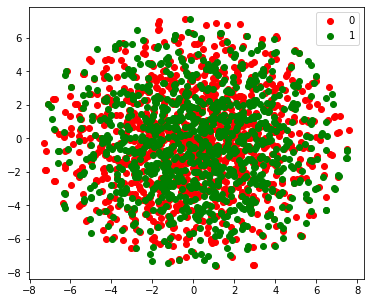

In [0]:
from matplotlib import pyplot as plt
plt.figure(figsize=(6, 5))
colors = 'r', 'g'
for i, c, label in zip(target_ids, colors, target_names):
    plt.scatter(X_2d[y_train==i, 0], X_2d[y_train==i, 1], c=c, label=label)
plt.legend()
plt.show()